# Description
The purpose of this notebook is to do prospection on data obtained from scriping interests links and Zefix results.

Indeed, on issue that may arise is that the data aren't clean enough to find usable results. In other words, we can have this two type of errors:

- False positive: for example, we search for a company linked with a politician, and we obtain on a lot of different companies
- False negatives: data isn't clean and thus can't find the real company in Zefix

This notebook is trying to have an insight on this two issues.

# Set-up

In [1]:
import os
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from zefix_scraper import zefix_search_raw

In [2]:
def count_findings(name):
    """
    Count how many findings zefix has done.
    """
    page = zefix_search_raw(name)
    
    if page is None:
        return 0

    content = BeautifulSoup(page, 'lxml')
    
    return len(content.body.find_all('p')) -1

def cached_call(generator, filename, as_series=False):
    """
    Simple function that try to load from cache or generate data (and cache it)
    
    `generator` must returns a DataFrame (and not a Series) in order to simplify the work.
    """
    path = os.path.join('cache', "{}.json".format(filename))
    try:
        if as_series:
            ans = pd.read_json(path, typ='series', orient='records')
        else:
            ans = pd.read_json(path)
    except Exception as e:
        print("Loading data... ({})".format(e))
        ans = generator()
        ans.to_json(path)
        
    return ans

In [3]:
interests = pd.read_json('data/all_interests.json')
interests

,data_source,first_name,index,interest_name,last_name,position
0,federal_parliament,Christoph,68,Kraftwerk Birsfelden AG,Eymann,Membre
1,federal_parliament,Christoph,68,Universität Basel (Universitätsrat),Eymann,Membre
10,federal_parliament,Ulrich,85,Online Easy AG,Giezendanner,Vice-président(e)
100,federal_parliament,Kathy,439,Organe consultatif sur les changements climati...,Riklin,Président(e)
1000,federal_parliament,Albert,3372,IG Volkskultur Schweiz und Fürstentum Liechten...,Vitali,Président(e)
1001,federal_parliament,Albert,3372,Pro Senectute Kanton Luzern (Stiftungsversamml...,Vitali,Membre
1002,federal_parliament,Albert,3372,Energie Oberkirch AG,Vitali,Président(e)
1003,federal_parliament,Albert,3372,Schweizer Verband für Rechnungslegung,Vitali,Membre
1004,federal_parliament,Albert,3372,Wohnen Schweiz,Vitali,Membre
1005,federal_parliament,Albert,3372,Förderverein Luzern Volksschulen,Vitali,Membre


# Naive lookup

In [4]:
import concurrent.futures

all_interests = interests.interest_name.unique()

def lookup_interests(all_interests):
    """
    Propagates Zefix lookups asynchronously usint a thread pool.
    
    The argument is simply a list, and the result is a DataFrame containing the interest as 
    a key and a value unique field called `findings_count`. 
    
    This method should be refactored before being used elsewhere because:
    - Not clean to have a simple list in argument, should use Pandas' Series
    - Not clean to have a DataFrame in output, should have a serie which maintains the same index
    """
    all_interests = map(lambda x: x.strip(), all_interests)
    all_interest_count = {}

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures_data = {executor.submit(count_findings, interest): interest for interest in all_interests}

        for future in concurrent.futures.as_completed(futures_data):
            interest = futures_data[future]
            try:
                count = future.result()
            except Exception as e:
                print("{} generated exception: {}".format(interest, e))
            else: 
                all_interest_count[interest] = count
            
    return pd.DataFrame(all_interest_count, index=["findings_count"]).transpose()

found_interests = cached_call(lambda : lookup_interests(all_interests), 'interests_counts')
found_interests = found_interests.findings_count
found_interests

"Ron" Anlage-Aktiengesellschaft                                                  1
022 Télégenève SA                                                                0
3 B Holding                                                                      1
95C                                                                              0
A Planer AG                                                                      0
ACQUAROSSA TERME SA                                                              0
ADEV Energiegenossenschaft                                                       0
AEBI Reisen GmbH                                                                 0
AECA Bundesgasse 20 Bern                                                         0
AEE Suisse                                                                       0
AEK Energie AG                                                                   0
AESP SA                                                                          0
AFU 

In [5]:
found_interests.describe()

count    2599.000000
mean        0.157753
std         1.757347
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        79.000000
Name: findings_count, dtype: float64

In [6]:
found_interests.sort_values(ascending=False)

Partner Immobilien AG                                                              79
Edy Toscano AG                                                                     18
Lions Club                                                                         14
BKW AG                                                                             13
PricewaterhouseCoopers AG                                                          13
Groupe E SA                                                                         9
ICT Switzerland                                                                     9
Securitas SA                                                                        8
Repi SA                                                                             8
EXPERTsuisse                                                                        8
De Martin AG                                                                        8
Regazzi SA                                            

In [7]:
def describe_ratios(serie):
    data = [
        ("equal_one", (serie == 1).mean()),
        ("null", (serie == 0).mean()),
        ("more_one", (serie > 1).mean()),
    ]
    
    for k,v in data:
        print("{}: {:0.1f}%".format(k,v * 100))

describe_ratios(found_interests)

equal_one: 3.9%
null: 94.2%
more_one: 1.9%


As we can see, the vast majority of Zefix lookups have no result (roughly 75%), while 8% have more than one results.

On the 75% of lookups having no results, some are true negative (i.e. the legal entity isn't registered in the Commercial Register, which is totally valid on some cases). However, 85% looks to be a lot too much.

# Resolve more lookups

Let have a look to the distribution of terms in the interest list

In [8]:
from wordcloud import WordCloud

In [9]:
def flatten(l):
    return [val for sublist in l for val in sublist]

def strip_flatten(l):
    return [e.strip() for e in flatten(l)]

all_words = pd.Series(strip_flatten([interest.split() for interest in all_interests]))
all_words 

0                     Kraftwerk
1                    Birsfelden
2                            AG
3                   Universität
4                         Basel
5             (Universitätsrat)
6                        Online
7                          Easy
8                            AG
9                        Organe
10                  consultatif
11                          sur
12                          les
13                  changements
14                  climatiques
15                       (OcCC)
16                  (Beratendes
17                       Organ)
18                           IG
19                  Volkskultur
20                      Schweiz
21                          und
22                   Fürstentum
23                Liechtenstein
24                          Pro
25                    Senectute
26                       Kanton
27                       Luzern
28       (Stiftungsversammlung)
29                      Energie
                  ...          
10314   

In [10]:
len(all_words)

10344

In [11]:
grouped_words = all_words.groupby(all_words).count()
grouped_words.sort_values(ascending=False)

de                  445
AG                  274
des                 265
SA                  210
Association         174
Fondation           134
Stiftung            131
du                  125
la                  125
Genève              111
für                 107
et                  102
Schweiz              87
der                  87
pour                 84
und                  81
Suisse               60
suisse               53
Société              46
Schweizerische       45
Pro                  39
Verband              38
Schweizerischer      37
Commission           36
Club                 36
-                    33
Zürich               32
Kanton               32
Verein               29
Holding              29
                   ... 
R.                    1
RADIO                 1
RADIX                 1
REGI                  1
Recycling             1
Rechtsschutz          1
Rechtspraxis          1
Rechtspflege          1
Recht                 1
Rechnungslegung       1
Recherches      

In [12]:
describe_ratios(grouped_words)

equal_one: 76.9%
null: 0.0%
more_one: 23.1%


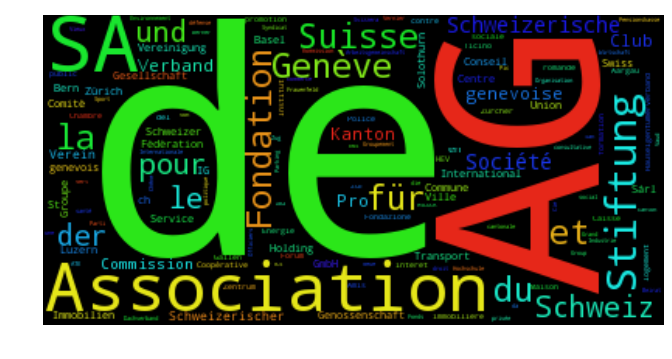

In [13]:
def show_cloud(words):
    cloud = WordCloud().generate(' '.join(words))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()
    
show_cloud(all_words)

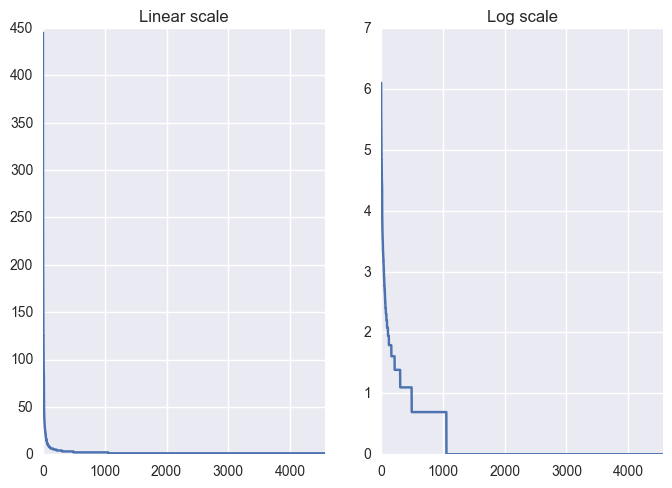

In [14]:
ordered = grouped_words.sort_values(ascending=False).reset_index(drop=True)

fig, axs = plt.subplots(1,2)
ordered.plot(ax=axs[0])
ordered.apply(np.log).plot(ax=axs[1])

axs[0].set_title("Linear scale")
axs[1].set_title("Log scale")

As we can see, there is _very few very frequent_ words, and a lot of non-frequent word. In this case - rather than on standard information retrieval – low frequence words might be worth considering, since companies have precise names.

## Tokenizer pipeline

Let check parenthesis in the data (which might be a problem)

In [15]:
interests[interests.interest_name.str.contains('\(')]

,data_source,first_name,index,interest_name,last_name,position
1,federal_parliament,Christoph,68,Universität Basel (Universitätsrat),Eymann,Membre
100,federal_parliament,Kathy,439,Organe consultatif sur les changements climati...,Riklin,Président(e)
1001,federal_parliament,Albert,3372,Pro Senectute Kanton Luzern (Stiftungsversamml...,Vitali,Membre
1009,federal_parliament,Stefan,3373,Lazzarini (Bau) AG,Engler,Président(e)
101,federal_parliament,Kathy,439,Schweizerische Vereinigung für Geothermie (SVG),Riklin,Membre
1011,federal_parliament,Stefan,3373,Gebäudeversicherung Graubünden (Verwaltungskom...,Engler,Membre
1021,federal_parliament,Daniel,3374,Konferenz der kantonalen Direktoren des öffent...,Fässler,Membre
1022,federal_parliament,Daniel,3374,Konferenz kantonaler Volkswirtschaftsdirektore...,Fässler,Membre
1026,federal_parliament,Daniel,3374,Verband der Immobilien-Investoren (VII),Fässler,Président(e)
1030,federal_parliament,Jacqueline,3376,Schweizerischer Mieterinnen- und Mieterverband...,Badran,Membre


In general, all of the content between the two parenthesis is irrelevant for the Zefix search (being either status or acronyms for the company). In both cases, this might result 

In [16]:
import re

def remove_parenthesis(text):
    return re.sub("\(.*\)?",'', text).strip()

clean_interests = interests.interest_name.apply(remove_parenthesis)
clean_interests

0                                 Kraftwerk Birsfelden AG
1                                       Universität Basel
10                                         Online Easy AG
100     Organe consultatif sur les changements climati...
1000    IG Volkskultur Schweiz und Fürstentum Liechten...
1001                          Pro Senectute Kanton Luzern
1002                                 Energie Oberkirch AG
1003                Schweizer Verband für Rechnungslegung
1004                                       Wohnen Schweiz
1005                     Förderverein Luzern Volksschulen
1006                                    Rhätische Bahn AG
1007                                     Grischelektra AG
1008                             Lazzarini Beteiligung AG
1009                                            Lazzarini
101             Schweizerische Vereinigung für Geothermie
1010                                  Schweizer Berghilfe
1011                       Gebäudeversicherung Graubünden
1012          

In [17]:
import nltk
from nltk.corpus import stopwords
#nltk.download()        # run once

def stringify_list(l):
    return ' '.join(l)

def tokenize_interest_pipeline(interest):
    def tokenize(interest):
        return nltk.word_tokenize(interest)
    
    def remove_stopwords(sentence):
        stop_words = stopwords.words(['german', 'french'])
        return [w for w in sentence if w.lower() not in stop_words]
    
    ans = remove_parenthesis(interest)
    ans = tokenize(ans)
    ans = remove_stopwords(ans)
    
    return ans

tokenized_interests = list(set(flatten([tokenize_interest_pipeline(i) for i in all_interests])))
sorted(tokenized_interests, key=len)

['R',
 "'",
 ':',
 '3',
 'V',
 '-',
 '+',
 '–',
 'F',
 '.',
 'E',
 'W',
 'P',
 '»',
 '/',
 ',',
 'e',
 'A',
 '«',
 '9',
 'a',
 'G',
 '&',
 '1',
 'I',
 'B',
 'GB',
 'R.',
 '21',
 'IG',
 '44',
 '89',
 '18',
 'ni',
 'AP',
 'kf',
 'RW',
 'MG',
 'hs',
 'Ja',
 'P.',
 'CC',
 'KV',
 '24',
 'CO',
 'HF',
 'AR',
 'Co',
 'al',
 "''",
 'u.',
 'H.',
 'ZH',
 '``',
 'up',
 'CH',
 'FH',
 'S.',
 'PS',
 'SI',
 'Ni',
 'ag',
 'VS',
 '3a',
 'W.',
 'SN',
 'II',
 'lo',
 'RI',
 'va',
 'JA',
 'RZ',
 'GE',
 '20',
 '86',
 'EA',
 '3R',
 'FC',
 'LU',
 'A.',
 'N.',
 'di',
 'AG',
 'VD',
 'fü',
 'IC',
 "'m",
 'TI',
 'of',
 'OK',
 'it',
 '54',
 'BEO',
 '360',
 'Max',
 'VCS',
 'CPP',
 'AFU',
 'KMU',
 'FMS',
 'Ron',
 'GSI',
 'Dr.',
 'BSU',
 'Lac',
 'a+b',
 'bat',
 'vie',
 'SIT',
 'VCT',
 'New',
 'del',
 'OdA',
 'ABD',
 'CGN',
 '102',
 'AEK',
 'UCS',
 'SKV',
 'TSE',
 'Inc',
 'DAL',
 'e.V',
 'Law',
 'XXL',
 'ACS',
 'MAH',
 'PRo',
 'SGV',
 'CSS',
 'EHC',
 'les',
 'Nie',
 'SAG',
 'EFS',
 'AVA',
 'GFG',
 'HST',
 'FEA',
 'KWD'

As we can see, there is token of size 1 which doens't provide a lot of information. Thus, we update the pipeline in order to remove it

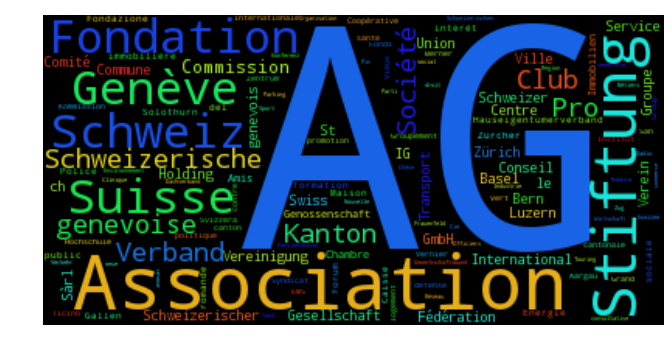

In [18]:
def more_one_letter_pipeline(interest):
    ans = tokenize_interest_pipeline(interest)
    
    return [token for token in ans if len(token) > 1]

tokenized_interests = flatten([more_one_letter_pipeline(i) for i in all_interests])
show_cloud(tokenized_interests)

As we can see, _AG_ is the most frequent word in the list now. It's an issue since it might provide enormously false-positive on Zefix search engine (due to its small size). Therefore, AG and SA are dropped:

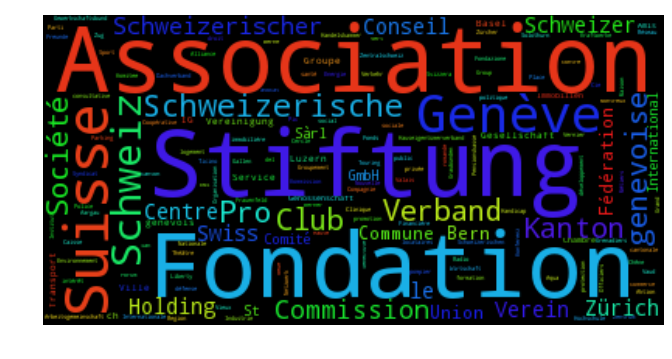

In [19]:
dark_words = ['AG','SA']

def remove_dark_words_pipeline(interest):
    return [token for token in more_one_letter_pipeline(interest) if token.upper() not in dark_words]

tokenized_interests = flatten([remove_dark_words_pipeline(i) for i in all_interests])
show_cloud(tokenized_interests)

## Sanitized search
Now that we've a pipeline for sanitizing interests, let do the lookup on Zefix

In [20]:
final_pipeline = remove_dark_words_pipeline
string_pipeline = lambda s: stringify_list(final_pipeline(s))

interests['sanitized_interest'] = interests.interest_name.apply(string_pipeline)
interests

,data_source,first_name,index,interest_name,last_name,position,sanitized_interest
0,federal_parliament,Christoph,68,Kraftwerk Birsfelden AG,Eymann,Membre,Kraftwerk Birsfelden
1,federal_parliament,Christoph,68,Universität Basel (Universitätsrat),Eymann,Membre,Universität Basel
10,federal_parliament,Ulrich,85,Online Easy AG,Giezendanner,Vice-président(e),Online Easy
100,federal_parliament,Kathy,439,Organe consultatif sur les changements climati...,Riklin,Président(e),Organe consultatif les changements climatiques
1000,federal_parliament,Albert,3372,IG Volkskultur Schweiz und Fürstentum Liechten...,Vitali,Président(e),IG Volkskultur Schweiz Fürstentum Liechtenstein
1001,federal_parliament,Albert,3372,Pro Senectute Kanton Luzern (Stiftungsversamml...,Vitali,Membre,Pro Senectute Kanton Luzern
1002,federal_parliament,Albert,3372,Energie Oberkirch AG,Vitali,Président(e),Energie Oberkirch
1003,federal_parliament,Albert,3372,Schweizer Verband für Rechnungslegung,Vitali,Membre,Schweizer Verband Rechnungslegung
1004,federal_parliament,Albert,3372,Wohnen Schweiz,Vitali,Membre,Wohnen Schweiz
1005,federal_parliament,Albert,3372,Förderverein Luzern Volksschulen,Vitali,Membre,Förderverein Luzern Volksschulen


In [21]:
all_sanitzed_interests = interests.sanitized_interest.unique()
found_sanitized_interests = cached_call(lambda : lookup_interests(all_sanitzed_interests), 'analyze_weak_lookup')

In [22]:
found_sanitized_interests.sort_values('findings_count', ascending=False)

,findings_count
and GmbH,1500
Immo,1500
ATE,1500
Holding,1500
AGE,1500
Alters-,560
Kaiser,217
GEWA,114
Mobility,85
CADES,83


In [23]:
describe_ratios(found_sanitized_interests.findings_count)

equal_one: 5.0%
null: 92.2%
more_one: 2.8%


# Mixing all together
Now that we've two methods that works differently, we should take advantage of both ones to have better results from Zefix.

The idea is to first look for unique result using an explicit lookup, and then to change the name of the interest for the other cases.

First, we need a new method for looking up Zefix

In [24]:
def async_series_lookup(f, input_series, number_parallel_tasks=None):
    """
    Asynchronous lookup for Pandas Series
    
    The argument is simply a list, and the result is a DataFrame containing the interest as 
    a key and a value unique field called `findings_count`. 
    
    Output: f(input_series) asynchronously
    
    f -- function to apply
    input_series -- Series to apply the function on
    """
    results = pd.Series()
    
    if number_parallel_tasks is not None:
        get_executor = lambda: concurrent.futures.ThreadPoolExecutor(max_workers=number_parallel_tasks)
    else:
        get_executor = lambda: concurrent.futures.ThreadPoolExecutor()

    with get_executor() as executor:
        futures_data = {executor.submit(f, val): key for (key, val) in input_series.iteritems()}

        for future in concurrent.futures.as_completed(futures_data):
            key = futures_data[future]
            try:
                ans = future.result()
            except Exception as e:
                print("{} generated exception: {}".format(key, e))
            else: 
                results.set_value(key, ans)
            
    return results

Now that we've this helper function, let call it on our data

In [25]:
resolved_interests = pd.DataFrame(all_interests, columns=['fullname'])
resolved_interests['sanitized_interest'] = resolved_interests.fullname.apply(string_pipeline)
resolved_interests

,fullname,sanitized_interest
0,Kraftwerk Birsfelden AG,Kraftwerk Birsfelden
1,Universität Basel (Universitätsrat),Universität Basel
2,Online Easy AG,Online Easy
3,Organe consultatif sur les changements climati...,Organe consultatif les changements climatiques
4,IG Volkskultur Schweiz und Fürstentum Liechten...,IG Volkskultur Schweiz Fürstentum Liechtenstein
5,Pro Senectute Kanton Luzern (Stiftungsversamml...,Pro Senectute Kanton Luzern
6,Energie Oberkirch AG,Energie Oberkirch
7,Schweizer Verband für Rechnungslegung,Schweizer Verband Rechnungslegung
8,Wohnen Schweiz,Wohnen Schweiz
9,Förderverein Luzern Volksschulen,Förderverein Luzern Volksschulen


## Strong lookup
Lookup the fullname entirely

In [26]:
resolved_interests['strong_lookup_counts'] = cached_call(lambda : async_series_lookup(count_findings, resolved_interests.fullname, number_parallel_tasks=None), 'strong_lookup_resolved', True)
resolved_interests

Loading data... (Expected object or value)


,fullname,sanitized_interest,strong_lookup_counts
0,Kraftwerk Birsfelden AG,Kraftwerk Birsfelden,2
1,Universität Basel (Universitätsrat),Universität Basel,0
2,Online Easy AG,Online Easy,1
3,Organe consultatif sur les changements climati...,Organe consultatif les changements climatiques,0
4,IG Volkskultur Schweiz und Fürstentum Liechten...,IG Volkskultur Schweiz Fürstentum Liechtenstein,0
5,Pro Senectute Kanton Luzern (Stiftungsversamml...,Pro Senectute Kanton Luzern,0
6,Energie Oberkirch AG,Energie Oberkirch,1
7,Schweizer Verband für Rechnungslegung,Schweizer Verband Rechnungslegung,0
8,Wohnen Schweiz,Wohnen Schweiz,0
9,Förderverein Luzern Volksschulen,Förderverein Luzern Volksschulen,0


## Weak lookup

In [27]:
def weak_lookup(resolved_interests):
    interests_to_look = resolved_interests[resolved_interests.strong_lookup_counts != 1].sanitized_interest
    ans = resolved_interests.strong_lookup_counts.copy()
    ans.update(async_series_lookup(count_findings, interests_to_look, number_parallel_tasks=None))
    
    return ans

resolved_interests['grouped_lookup_counts'] = cached_call(lambda: weak_lookup(resolved_interests), 'weak_lookup_resolved', True)
resolved_interests

Loading data... (Expected object or value)


,fullname,sanitized_interest,strong_lookup_counts,grouped_lookup_counts
0,Kraftwerk Birsfelden AG,Kraftwerk Birsfelden,2,2
1,Universität Basel (Universitätsrat),Universität Basel,0,0
2,Online Easy AG,Online Easy,1,1
3,Organe consultatif sur les changements climati...,Organe consultatif les changements climatiques,0,0
4,IG Volkskultur Schweiz und Fürstentum Liechten...,IG Volkskultur Schweiz Fürstentum Liechtenstein,0,0
5,Pro Senectute Kanton Luzern (Stiftungsversamml...,Pro Senectute Kanton Luzern,0,0
6,Energie Oberkirch AG,Energie Oberkirch,1,1
7,Schweizer Verband für Rechnungslegung,Schweizer Verband Rechnungslegung,0,0
8,Wohnen Schweiz,Wohnen Schweiz,0,0
9,Förderverein Luzern Volksschulen,Förderverein Luzern Volksschulen,0,0


## Check the results

In [28]:
describe_ratios(resolved_interests.grouped_lookup_counts)

equal_one: 6.8%
null: 91.1%
more_one: 2.1%
